In [1]:
import pandas as pd
import numpy as np
import os
import xlrd
from functools import reduce
from itertools import groupby
from matplotlib import pyplot as plt
plt.show()
import seaborn as sns; sns.set()
import altair as alt
alt.data_transformers.disable_max_rows()
import warnings
warnings.filterwarnings('ignore')


To read in these massive excel files first want to extract names of sheets

In [2]:
file1 = "/Users/quinnunderriner/Desktop/Work/eden_rent_roll/TenantLeasePayments_Trending_(Active)_May_2020_Sept_2020.xlsx"
file2 = "/Users/quinnunderriner/Desktop/Work/eden_rent_roll/Tenant_Lease_Payments_May 2019_Sept_2019.xlsx"

In [3]:
xls = xlrd.open_workbook(file1, on_demand=True)
may2020_sept2020 = xls.sheet_names()
may2020_sept2020 = [x for x in may2020_sept2020 if not x.endswith('Summary')] #we want to drop summary tabs 

In [4]:
# need to drop data from earlier in months where we have double data 
may2020_sept2020 = [x for x in may2020_sept2020 if not "15" in x]
may2020_sept2020 = [x for x in may2020_sept2020 if not "10" in x]


In [5]:
xls2 = xlrd.open_workbook(file2, on_demand=True)
may19_sept19 = xls2.sheet_names()

In [6]:
def read_in(file,sheet):
    """
    inputs:
        file (str): filepath of excel file
        sheet (str): name of sheet in excel sheet
    returns:
        df (dataframe)
    Read in data from a given excel sheet, do some cleaning and then 
    make new column names that adds the date for financial transaction 
    and drops the rest of the data. 
    """
    df = pd.read_excel(file,sheet_name =sheet)
    new_header = df.iloc[4] #grab the forth row for the header
    df = df[5:] #take the data less the blank rows
    df.columns = new_header
    df = df[:-2]#drop bottom two rows, which contain summary info
    df = df.reset_index().drop(columns=["index"])
    df = df[['Tenant Lease Charge','Is Subsidized?', 'Fixed Income?', 'Tenant Rent Collected',
             'Percent Collected',"Period","Tenant"]]
    df = df.rename(columns={"Tenant Lease Charge":"Tenant Lease Charge"+" "+df["Period"][5],
                   "Tenant Rent Collected":"Tenant Rent Charge"+" "+df["Period"][5],
                  "Percent Collected":"Tenant Percent Collected"+" "+df["Period"][5],
                   'Is Subsidized?':"Is Subsidized?"+" "+df["Period"][5], 
                    'Fixed Income?':"Fixed Income?"+" "+df["Period"][5]}) 
    df = df.drop(columns={"Period"})
    return df

In [7]:
def read_in_check_status(file,sheet):
    """
    inputs:
        file (str): filepath of excel file
        sheet (str): name of sheet in excel sheet
    returns:
        df (dataframe)
    Read in data from a given excel sheet, do some cleaning 
    """
    df = pd.read_excel(file,sheet_name =sheet)
    new_header = df.iloc[4] #grab the forth row for the header
    df = df[5:] #take the data less the blank rows
    df.columns = new_header
    df = df[:-2]#drop bottom two rows, which contain summary info
    df = df.reset_index().drop(columns=["index"])
    df = df.rename(columns={"Tenant Lease Charge":"Tenant Lease Charge"+" "+df["Period"][5],
                   "Tenant Rent Collected":"Tenant Rent Charge"+" "+df["Period"][5],
                  "Percent Collected":"Tenant Percent Collected"+" "+df["Period"][5]})

    #df = df.drop(columns={"Period"})
    return df

In [8]:
def make_header(df):
    """
    inputs:
        df (dataframe)
    returns:
        df (dataframe)
    do some basic cleanup of the header row 
    """
    new_header = df.iloc[4] #grab the forth row for the header
    df = df[5:] #take the data less the blank rows
    df.columns = new_header
    return df

In [9]:
#read in the correct sheets from all files calling read_in function 
df = read_in_check_status(file2,may19_sept19[0])

df_list = [df, read_in(file2,may19_sept19[1]),
           read_in(file2,may19_sept19[2]),
           read_in(file2,may19_sept19[3]),
           read_in(file2,may19_sept19[4]),
           read_in(file1,may2020_sept2020[0]),
           read_in(file1,may2020_sept2020[1]),
           read_in(file1,may2020_sept2020[2]),
           read_in(file1,may2020_sept2020[3]),
           read_in(file1,may2020_sept2020[4])]

In [10]:
#This lambda function then merges all the dataframes from df_list together 
df_final = reduce(lambda left,right: pd.merge(left,right,on='Tenant'), df_list)

df_final = df_final.drop(columns=["Name","Period"]) #drop cols

In [11]:
#write out initial data to csv
df_final.to_csv("Inital_eden_rent_roll_data_19-20_v2.csv")

In [12]:
#UPDATED SECTION TO REMOVE PROPERTIES ONLY ACTIVE IN 2020 
all_hands_on_the_bad_ones = ['Stone Pine Meadows','Quail Run Apartments','Lincoln Corner Apartments',
'Vacaville Meadows Drive','Orchard/Maples Apartments','Willows Apartments',
'Highlands Apartments', 'Hillside Senior Apartments']
df_final = df_final[~df_final["Property Name"].isin(all_hands_on_the_bad_ones)]

Q: “Have rent collections changed in 2020 compared to last year (e.g., collective rent roll shortfalls, number of tenants with underpayment or no payment in each month)?”
 


Need to melt dataset so each row is amount of rent collected in a given month to be able to do groupbys

In [13]:
#grab initial fixed columns for first month in dataset 
fixed_cols = ['Property', 'Property Name', 'City', 'County', 'Unit', 'Tenant',
       'Is Subsidized?', 'Fixed Income?']

In [14]:
# additionally grab just monthly percentage payment columns 
percent_collected = [num for num in df_final.columns if ("Percent") in num]

In [15]:
#merge these two lists in the total list of columns we want so we can melt dataset 
# for this initial analysis assuming that fixed income status and stuff do not change
collect = fixed_cols + percent_collected
df_rent_collected = df_final[collect]

In [16]:
#create a melted dataset so that each row is a payment 
monthly_percent_collected = pd.melt(df_rent_collected, id_vars=fixed_cols,var_name='Percent Collected')

In [17]:
# there are 83,220 payments in this dataset 
len(monthly_percent_collected)

83220

In [18]:
# to group by year, need a year col 
monthly_percent_collected["year"] = monthly_percent_collected["Percent Collected"].str[-2:]

In [19]:
monthly_percent_collected["Percent Collected"].value_counts()

Tenant Percent Collected 05/01/19 - 05/31/19    8322
Tenant Percent Collected 08/01/19 - 08/31/19    8322
Tenant Percent Collected 08/01/20 - 08/31/20    8322
Tenant Percent Collected 06/01/19 - 06/30/19    8322
Tenant Percent Collected 05/01/20 - 05/31/20    8322
Tenant Percent Collected 07/01/20 - 07/31/20    8322
Tenant Percent Collected 09/01/19 - 09/30/19    8322
Tenant Percent Collected 06/01/20 - 06/30/20    8322
Tenant Percent Collected 07/01/19 - 07/31/19    8322
Tenant Percent Collected 09/01/20 - 09/30/20    8322
Name: Percent Collected, dtype: int64

In [20]:
len(monthly_percent_collected[monthly_percent_collected.value > 100])

14022

In [21]:
#16 percent of all payments exceed total, implying paying back rent. 
len(monthly_percent_collected[monthly_percent_collected.value > 100])/ len(monthly_percent_collected)

0.1684931506849315

In [ ]:
#negative rent total 
len(monthly_percent_collected[monthly_percent_collected.value < 0])

In [23]:
(len(monthly_percent_collected[monthly_percent_collected.value < 0])/len(monthly_percent_collected))

0.0007570295602018746

In [24]:
#I'm going to drop these negative values as I believe them to be errors. 
monthly_percent_collected = monthly_percent_collected[monthly_percent_collected.value >= 0]

In [25]:
monthly_percent_collected.value = monthly_percent_collected.value.astype(float) #make value type that works with groupby 
monthly_percent_collected[monthly_percent_collected.value <=100][["year","value"]].groupby("year").describe().round(2)

value                                               
        count   mean    std  min    25%    50%    75%    max
year                                                        
19    34137.0  87.02  33.01  0.0  100.0  100.0  100.0  100.0
20    34998.0  91.26  26.87  0.0  100.0  100.0  100.0  100.0

In [26]:
#count the number of non payments per year 
monthly_percent_collected_zeros = monthly_percent_collected[["year","value"]].groupby('year').agg(lambda x: x.eq(0).sum())



In [90]:
monthly_percent_collected_zeros

,value
year,
19,4188.0
20,2532.0


Q: “For tenants who are short or don't pay rent...is that typically a one-off thing or are they likely to be in arrears multiple months. How far short do they tend to be? Has that shifted in 2020?”

In [29]:
#create a datetime column to make altair happy 
monthly_percent_collected_chart = monthly_percent_collected
monthly_percent_collected_chart["Percent Collected"] = monthly_percent_collected_chart["Percent Collected"].str[-8:]
monthly_percent_collected_chart["Percent Collected"] = pd.to_datetime(monthly_percent_collected_chart["Percent Collected"])

In [30]:
monthly_percent_collected_chart = monthly_percent_collected_chart[["value","Percent Collected"]].groupby("Percent Collected").mean().reset_index()

In [31]:
#melt, group by person, do a value counts 
people_with_nonpayment = df_rent_collected.loc[~(df_rent_collected != 0).all(axis=1), :]
len(people_with_nonpayment)

1905

There are 1905 people who have at least one nonpayment.


In [32]:
people_with_nonpayment_data_only = people_with_nonpayment[percent_collected]

In [34]:
people_with_nonpayment_data_only.head()

4,Tenant Percent Collected 05/01/19 - 05/31/19,Tenant Percent Collected 06/01/19 - 06/30/19,Tenant Percent Collected 07/01/19 - 07/31/19,Tenant Percent Collected 08/01/19 - 08/31/19,Tenant Percent Collected 09/01/19 - 09/30/19,Tenant Percent Collected 05/01/20 - 05/31/20,Tenant Percent Collected 06/01/20 - 06/30/20,Tenant Percent Collected 07/01/20 - 07/31/20,Tenant Percent Collected 08/01/20 - 08/31/20,Tenant Percent Collected 09/01/20 - 09/30/20
2,0,0,0,0,0,100,100,100,100,100
5,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,100,100,100,100,100
44,0,0,0,0,0,100,100,100,100,100
46,0,0,307.89,100,100,100,100,100,100,100


In [33]:
#people_with_nonpayment_data_only = people_with_nonpayment_data_only.drop(columns="conseq_0")
#people_with_nonpayment_data_only = people_with_nonpayment[percent_collected]

KeyError: "['conseq_0'] not found in axis"

In [36]:
def count0(a):
    b = [sum(1 for i in g) for k,g in groupby(a) if k==0]
    if len(b)>0:
        return b
    else:
        return [0]
people_with_nonpayment_data_only['zeros2'] = people_with_nonpayment_data_only.apply(lambda x: count0(x.values), axis=1)

In [37]:
nonpayment_stretches = []
for i in people_with_nonpayment_data_only.zeros2:
    nonpayment_stretches += i


In [38]:
sum(nonpayment_stretches)/len(nonpayment_stretches)

2.77800744109136

now we want to see if this calculation differs by year

In [75]:
people_with_nonpayment_19 = people_with_nonpayment[[x for x in people_with_nonpayment if  x.endswith('19')]]
people_with_nonpayment_20 = people_with_nonpayment[[x for x in people_with_nonpayment if  x.endswith('20')]]

In [76]:
people_with_nonpayment_19['zeros2'] = people_with_nonpayment_19.apply(lambda x: count0(x.values), axis=1)
people_with_nonpayment_20['zeros2'] = people_with_nonpayment_20.apply(lambda x: count0(x.values), axis=1)


In [77]:
people_with_nonpayment_20.head()

4,Tenant Percent Collected 05/01/20 - 05/31/20,Tenant Percent Collected 06/01/20 - 06/30/20,Tenant Percent Collected 07/01/20 - 07/31/20,Tenant Percent Collected 08/01/20 - 08/31/20,Tenant Percent Collected 09/01/20 - 09/30/20,zeros2
2,100,100,100,100,100,[0]
5,0,0,0,0,0,[5]
7,100,100,100,100,100,[0]
44,100,100,100,100,100,[0]
46,100,100,100,100,100,[0]


In [78]:
def count_nonpayment(df):
    nonpayment_stretches = []
    for i in people_with_nonpayment_data_only.zeros2:
        nonpayment_stretches += i
    return sum(nonpayment_stretches)/len(nonpayment_stretches)

In [79]:
nonpayment_stretches_19 = []
for i in people_with_nonpayment_19.zeros2:
    nonpayment_stretches_19 += i
sum(nonpayment_stretches_19)/len(nonpayment_stretches_19)

2.129130655821047

(array([677.,   0., 437.,   0.,  99.,   0.,  82.,   0.,  53., 619.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

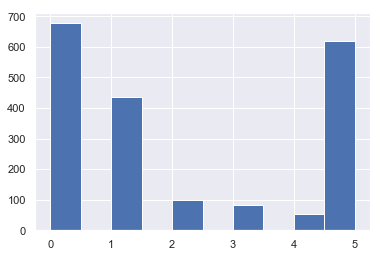

In [80]:
plt.hist(nonpayment_stretches_19)

In [81]:
nonpayment_stretches_20 = []
for i in people_with_nonpayment_20.zeros2:
    nonpayment_stretches_20 += i
sum(nonpayment_stretches_20)/len(nonpayment_stretches_20)

1.1842843779232928

(array([764.,   0., 925.,   0., 154.,   0.,  77.,   0.,  22., 196.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

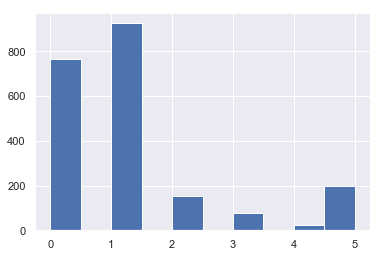

In [82]:
plt.hist(nonpayment_stretches_20)

In [83]:
nonpayment_only = people_with_nonpayment[['Tenant Percent Collected 05/01/19 - 05/31/19',
       'Tenant Percent Collected 06/01/19 - 06/30/19',
       'Tenant Percent Collected 07/01/19 - 07/31/19',
       'Tenant Percent Collected 08/01/19 - 08/31/19',
       'Tenant Percent Collected 09/01/19 - 09/30/19',
       'Tenant Percent Collected 05/01/20 - 05/31/20',
       'Tenant Percent Collected 06/01/20 - 06/30/20',
       'Tenant Percent Collected 07/01/20 - 07/31/20',
       'Tenant Percent Collected 08/01/20 - 08/31/20',
       'Tenant Percent Collected 09/01/20 - 09/30/20']]

In [84]:
melted_nonpayment = pd.melt(people_with_nonpayment, id_vars=fixed_cols,var_name='Percent Collected')

In [85]:
melted_nonpayment = melted_nonpayment[['Tenant', 'value']]
melted_nonpayment.value = melted_nonpayment.value.astype(float)

now calculate the total number of nonpayments in the dataset

6720 Total nonpayments in the dataset. 

In [86]:
(melted_nonpayment.value == 0).sum()

6720

In [87]:
melted_nonpayment_des = melted_nonpayment.groupby("Tenant").describe().reset_index()

In [91]:
monthly_percent_collected.head()

,Property,Property Name,City,County,Unit,Tenant,Is Subsidized?,Fixed Income?,Date Collected,Percentage of Rent Paid,year,Assistance,Aid
0,304,Almond Terrace,Manteca,San Joaquin,A101,t0028148,Yes Subsidy,No Assistance,2019-05-31,98.98,19,Yes Subsidy No Assistance,Aid
1,304,Almond Terrace,Manteca,San Joaquin,A102,t0009751,Yes Subsidy,No Assistance,2019-05-31,100.00,19,Yes Subsidy No Assistance,Aid
2,304,Almond Terrace,Manteca,San Joaquin,A103,t0029469,No Subsidy,No Assistance,2019-05-31,0.00,19,No Subsidy No Assistance,No Aid
3,304,Almond Terrace,Manteca,San Joaquin,A104,t0023101,Yes Subsidy,No Assistance,2019-05-31,100.00,19,Yes Subsidy No Assistance,Aid
4,304,Almond Terrace,Manteca,San Joaquin,A105,t0000702,Yes Subsidy,SS,2019-05-31,100.00,19,Yes Subsidy SS,Aid


In [93]:
monthly_percent_collected["Fixed Income?"] = monthly_percent_collected["Fixed Income?"].replace(np.nan, 'No Assistance', regex=True)
monthly_percent_collected[["Fixed Income?","Percentage of Rent Paid"]].groupby("Fixed Income?").mean().round(2)

,Percentage of Rent Paid
Fixed Income?,
No Assistance,85.06
SS,97.24
SS/SSI,97.47
SSI,96.80


In [94]:
monthly_percent_collected.head()

,Property,Property Name,City,County,Unit,Tenant,Is Subsidized?,Fixed Income?,Date Collected,Percentage of Rent Paid,year,Assistance,Aid
0,304,Almond Terrace,Manteca,San Joaquin,A101,t0028148,Yes Subsidy,No Assistance,2019-05-31,98.98,19,Yes Subsidy No Assistance,Aid
1,304,Almond Terrace,Manteca,San Joaquin,A102,t0009751,Yes Subsidy,No Assistance,2019-05-31,100.00,19,Yes Subsidy No Assistance,Aid
2,304,Almond Terrace,Manteca,San Joaquin,A103,t0029469,No Subsidy,No Assistance,2019-05-31,0.00,19,No Subsidy No Assistance,No Aid
3,304,Almond Terrace,Manteca,San Joaquin,A104,t0023101,Yes Subsidy,No Assistance,2019-05-31,100.00,19,Yes Subsidy No Assistance,Aid
4,304,Almond Terrace,Manteca,San Joaquin,A105,t0000702,Yes Subsidy,SS,2019-05-31,100.00,19,Yes Subsidy SS,Aid


In [95]:
df_rent_collected["Fixed Income?"] = df_rent_collected["Fixed Income?"].replace(np.nan, 'No Assistance', regex=True)
df_rent_collected["Is Subsidized?"] = df_rent_collected["Is Subsidized?"].replace(np.nan, 'No', regex=True)
df_rent_collected["Is Subsidized?"] = df_rent_collected["Is Subsidized?"] + " " + "Subsidy"
df_rent_collected["Assistance"] = df_rent_collected["Is Subsidized?"] +" "+ df_rent_collected["Fixed Income?"]

In [96]:
df_rent_collected["Fixed Income?"].value_counts()

No Assistance    5576
SS               1361
SSI               750
SS/SSI            635
Name: Fixed Income?, dtype: int64

In [97]:
df_rent_collected["Is Subsidized?"].value_counts()

No Subsidy     4875
Yes Subsidy    3447
Name: Is Subsidized?, dtype: int64

In [98]:
4507 /(5617 + 3447)

0.49724183583406883

0.49 percent of people have no form of gov assistance 

In [99]:
df_rent_collected["Assistance"].value_counts()

No Subsidy No Assistance     3844
Yes Subsidy No Assistance    1732
Yes Subsidy SS                768
No Subsidy SS                 593
Yes Subsidy SSI               485
Yes Subsidy SS/SSI            462
No Subsidy SSI                265
No Subsidy SS/SSI             173
Name: Assistance, dtype: int64

In [100]:
monthly_percent_collected["Assistance"] = monthly_percent_collected["Is Subsidized?"] +" "+ monthly_percent_collected["Fixed Income?"]

In [101]:
monthly_percent_collected = monthly_percent_collected.rename(columns={"value":"Percentage of Rent Paid"})

In [102]:
monthly_percent_collected[["Fixed Income?","Percentage of Rent Paid","year"]].groupby(["Fixed Income?","year"]).mean().round(2)

Percentage of Rent Paid
Fixed Income? year                         
No Assistance 19                      81.55
              20                      88.51
SS            19                      97.90
              20                      96.61
SS/SSI        19                      97.59
              20                      97.35
SSI           19                      97.82
              20                      95.83

In [103]:
monthly_percent_collected[["Is Subsidized?","Percentage of Rent Paid","year"]].groupby(["Is Subsidized?","year"]).mean()

Percentage of Rent Paid
Is Subsidized? year                         
No Subsidy     19                  81.805073
               20                  90.165662
Yes Subsidy    19                  94.768673
               20                  92.836676

In [104]:
monthly_percent_collected["Fixed Income?"] = monthly_percent_collected["Fixed Income?"].replace(np.nan, 'No Assistance', regex=True)
monthly_percent_collected["Is Subsidized?"] = monthly_percent_collected["Is Subsidized?"].replace(np.nan, 'No', regex=True)
monthly_percent_collected["Is Subsidized?"] = monthly_percent_collected["Is Subsidized?"] + " " + "Subsidy"
monthly_percent_collected["Assistance"] = monthly_percent_collected["Is Subsidized?"] +" "+ monthly_percent_collected["Fixed Income?"]

In [105]:
monthly_percent_collected["Assistance"].value_counts()

No Subsidy Subsidy No Assistance     32050
Yes Subsidy Subsidy No Assistance    13661
Yes Subsidy Subsidy SS                6473
No Subsidy Subsidy SS                 5245
Yes Subsidy Subsidy SSI               4021
Yes Subsidy Subsidy SS/SSI            3894
No Subsidy Subsidy SSI                2297
No Subsidy Subsidy SS/SSI             1494
Name: Assistance, dtype: int64

In [106]:
def any_aid(x):
    if x == "No Subsidy No Assistance":
        return "No Aid"
    else:
        return "Aid"

In [107]:
monthly_percent_collected["Aid"] = monthly_percent_collected.Assistance.apply(lambda x: any_aid(x))

In [134]:
monthly_percent_collected[["Aid","Percentage of Rent Paid","year"]].groupby(["Aid","year"]).mean().round(2)

Percentage of Rent Paid
Aid year                         
Aid 19                      87.02
    20                      91.26

In [109]:
monthly_percent_collected["Percentage of Rent Paid"].value_counts()

100.00    56796
0.00       6720
99.91        80
99.93        50
96.00        50
          ...  
81.51         1
79.56         1
78.44         1
87.26         1
93.15         1
Name: Percentage of Rent Paid, Length: 2073, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11de0dd30>]],
      dtype=object)

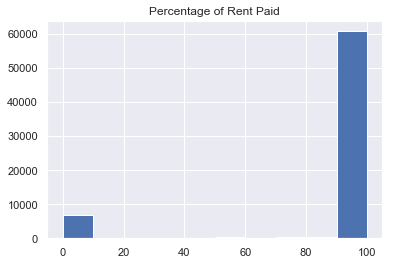

In [110]:
monthly_percent_collected[monthly_percent_collected["Percentage of Rent Paid"]<=100].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e497828>]],
      dtype=object)

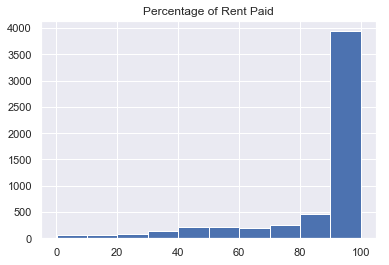

In [111]:
extra_hist = monthly_percent_collected[monthly_percent_collected["Percentage of Rent Paid"]<100]
extra_hist = extra_hist[extra_hist["Percentage of Rent Paid"]>0]
extra_hist.hist()

In [157]:
monthly_percent_collected_chart = monthly_percent_collected_chart.rename({"Percent Collected":"Date","Avg_Percent_of_Rent_Paid":"value"})

In [159]:
line = line_chart = alt.Chart(monthly_percent_collected_chart).mark_line(color="#FFAA00").encode(
        alt.X('Percent Collected',
        scale=alt.Scale(zero=False)
    ),


    alt.Y("value", scale=alt.Scale(zero=False))
)

band = line_chart = alt.Chart(monthly_percent_collected_chart).mark_errorband(extent='ci').encode(
        alt.X('Percent Collected',
        scale=alt.Scale(zero=False)
    ),


    alt.Y("value", scale=alt.Scale(zero=False))
)

band + line

alt.LayerChart(...)

In [112]:
monthly_percent_collected.head()

,Property,Property Name,City,County,Unit,Tenant,Is Subsidized?,Fixed Income?,Date Collected,Percentage of Rent Paid,year,Assistance,Aid
0,304,Almond Terrace,Manteca,San Joaquin,A101,t0028148,Yes Subsidy Subsidy,No Assistance,2019-05-31,98.98,19,Yes Subsidy Subsidy No Assistance,Aid
1,304,Almond Terrace,Manteca,San Joaquin,A102,t0009751,Yes Subsidy Subsidy,No Assistance,2019-05-31,100.00,19,Yes Subsidy Subsidy No Assistance,Aid
2,304,Almond Terrace,Manteca,San Joaquin,A103,t0029469,No Subsidy Subsidy,No Assistance,2019-05-31,0.00,19,No Subsidy Subsidy No Assistance,Aid
3,304,Almond Terrace,Manteca,San Joaquin,A104,t0023101,Yes Subsidy Subsidy,No Assistance,2019-05-31,100.00,19,Yes Subsidy Subsidy No Assistance,Aid
4,304,Almond Terrace,Manteca,San Joaquin,A105,t0000702,Yes Subsidy Subsidy,SS,2019-05-31,100.00,19,Yes Subsidy Subsidy SS,Aid


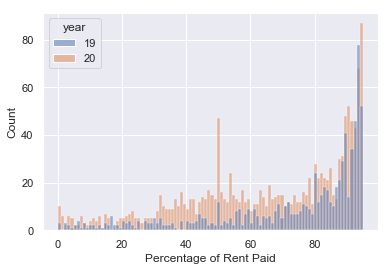

In [113]:
group_hist = monthly_percent_collected[monthly_percent_collected["Percentage of Rent Paid"]<95]
group_hist = group_hist[group_hist["Percentage of Rent Paid"]>0]
sns.histplot(data=group_hist, x="Percentage of Rent Paid", hue="year", bins=100
            )

Q: “Are rent shortfalls concentrated in certain properties or regions of the state?”


In [114]:
monthly_percent_collected = monthly_percent_collected[monthly_percent_collected["Percentage of Rent Paid"]<=100]

In [115]:
by_county = monthly_percent_collected[["County","Percentage of Rent Paid"]].groupby("County").describe().reset_index()

In [116]:
by_county.sort_values([('Percentage of Rent Paid', 'mean')], ascending=False).round(2)

County Percentage of Rent Paid                                    \
                                   count   mean    std  min     25%    50%   
7      San Diego                  5002.0  95.61  19.26  0.0  100.00  100.0   
6     San Benito                   955.0  94.52  20.74  0.0  100.00  100.0   
11    Santa Cruz                  2219.0  94.03  23.04  0.0  100.00  100.0   
8    San Joaquin                  2165.0  93.75  24.00  0.0  100.00  100.0   
5         Orange                  1284.0  92.94  23.84  0.0  100.00  100.0   
13        Sonoma                  3637.0  92.22  26.16  0.0  100.00  100.0   
4       Monterey                  3409.0  91.70  26.47  0.0  100.00  100.0   
10   Santa Clara                 13595.0  90.98  27.81  0.0  100.00  100.0   
0        Alameda                 23202.0  87.45  32.16  0.0  100.00  100.0   
3          Marin                   957.0  86.88  32.94  0.0  100.00  100.0   
2    Los Angeles                   320.0  85.81  33.49  0.0  100.00  100.0   
1   Contra Costa                  8102.0  85.71  33.98  0.0  100.00  100.0   
12        Solano                  2825.0  82.18  37.24  0.0   99.25  100.0   
14          Yolo                  1340.0  77.93  40.11  0.0   94.88  100.0   
9      San Mateo                   123.0  77.19  42.08  0.0   99.08  100.0   

                  
      75%    max  
7   100.0  100.0  
6   100.0  100.0  
11  100.0  100.0  
8   100.0  100.0  
5   100.0  100.0  
13  100.0  100.0  
4   100.0  100.0  
10  100.0  100.0  
0   100.0  100.0  
3   100.0  100.0  
2   100.0  100.0  
1   100.0  100.0  
12  100.0  100.0  
14  100.0  100.0  
9   100.0  100.0

In [117]:
#calculate number of nonpayments by 
no_payments_county = people_with_nonpayment.groupby("County").count().reset_index()[["County","Property"]]
total_counts = df_rent_collected.groupby("County").count().reset_index()[["County","Property"]]
no_payments_county = no_payments_county.merge(total_counts,on="County")
no_payments_county["No Payment as a Percent of Total Payments"] = no_payments_county.Property_x/no_payments_county.Property_y

In [118]:
people_with_nonpayment[people_with_nonpayment["Property Name"] == "Quail Run Apartments"]


4,Property,Property Name,City,County,Unit,Tenant,Is Subsidized?,Fixed Income?,Tenant Percent Collected 05/01/19 - 05/31/19,Tenant Percent Collected 06/01/19 - 06/30/19,Tenant Percent Collected 07/01/19 - 07/31/19,Tenant Percent Collected 08/01/19 - 08/31/19,Tenant Percent Collected 09/01/19 - 09/30/19,Tenant Percent Collected 05/01/20 - 05/31/20,Tenant Percent Collected 06/01/20 - 06/30/20,Tenant Percent Collected 07/01/20 - 07/31/20,Tenant Percent Collected 08/01/20 - 08/31/20,Tenant Percent Collected 09/01/20 - 09/30/20


In [119]:
no_payments_county = no_payments_county[["County","No Payment as a Percent of Total Payments"]]
no_payments_county.sort_values("No Payment as a Percent of Total Payments",ascending=False).reset_index().drop(columns={"index"}).round(3)

4,County,No Payment as a Percent of Total Payments
0,Solano,0.383
1,Yolo,0.373
2,Contra Costa,0.323
3,Marin,0.318
4,Los Angeles,0.310
5,Alameda,0.255
6,San Mateo,0.219
7,Monterey,0.216
8,Santa Clara,0.192
9,Sonoma,0.162


“Are rent shortfalls concentrated in certain properties?"

In [120]:
monthly_percent_collected =monthly_percent_collected.rename(columns={"Percent Collected":"Date Collected"})

In [121]:
monthly_percent_collected.head()

,Property,Property Name,City,County,Unit,Tenant,Is Subsidized?,Fixed Income?,Date Collected,Percentage of Rent Paid,year,Assistance,Aid
0,304,Almond Terrace,Manteca,San Joaquin,A101,t0028148,Yes Subsidy Subsidy,No Assistance,2019-05-31,98.98,19,Yes Subsidy Subsidy No Assistance,Aid
1,304,Almond Terrace,Manteca,San Joaquin,A102,t0009751,Yes Subsidy Subsidy,No Assistance,2019-05-31,100.00,19,Yes Subsidy Subsidy No Assistance,Aid
2,304,Almond Terrace,Manteca,San Joaquin,A103,t0029469,No Subsidy Subsidy,No Assistance,2019-05-31,0.00,19,No Subsidy Subsidy No Assistance,Aid
3,304,Almond Terrace,Manteca,San Joaquin,A104,t0023101,Yes Subsidy Subsidy,No Assistance,2019-05-31,100.00,19,Yes Subsidy Subsidy No Assistance,Aid
4,304,Almond Terrace,Manteca,San Joaquin,A105,t0000702,Yes Subsidy Subsidy,SS,2019-05-31,100.00,19,Yes Subsidy Subsidy SS,Aid


In [122]:
by_property = monthly_percent_collected[["Property Name","City","County","Percentage of Rent Paid"]].groupby("Property Name").describe().reset_index().round(2)
by_property = by_property.sort_values([('Percentage of Rent Paid', 'mean')], ascending=False).round(2)

In [123]:
#get ride of multi index
by_property.columns = by_property.columns.map(' '.join)
by_property = by_property.sort_values([('Percentage of Rent Paid mean')], ascending=False).round(2)

In [124]:
monthly_percent_collected.head()

,Property,Property Name,City,County,Unit,Tenant,Is Subsidized?,Fixed Income?,Date Collected,Percentage of Rent Paid,year,Assistance,Aid
0,304,Almond Terrace,Manteca,San Joaquin,A101,t0028148,Yes Subsidy Subsidy,No Assistance,2019-05-31,98.98,19,Yes Subsidy Subsidy No Assistance,Aid
1,304,Almond Terrace,Manteca,San Joaquin,A102,t0009751,Yes Subsidy Subsidy,No Assistance,2019-05-31,100.00,19,Yes Subsidy Subsidy No Assistance,Aid
2,304,Almond Terrace,Manteca,San Joaquin,A103,t0029469,No Subsidy Subsidy,No Assistance,2019-05-31,0.00,19,No Subsidy Subsidy No Assistance,Aid
3,304,Almond Terrace,Manteca,San Joaquin,A104,t0023101,Yes Subsidy Subsidy,No Assistance,2019-05-31,100.00,19,Yes Subsidy Subsidy No Assistance,Aid
4,304,Almond Terrace,Manteca,San Joaquin,A105,t0000702,Yes Subsidy Subsidy,SS,2019-05-31,100.00,19,Yes Subsidy Subsidy SS,Aid


In [125]:
locations = monthly_percent_collected[["City","County","Property Name"]]

In [126]:
by_property = by_property.rename(columns={"Property Name ":"Property Name"})

In [127]:
locations.columns

Index(['City', 'County', 'Property Name'], dtype='object')

In [128]:
by_property = by_property.merge(locations,on="Property Name")

In [129]:
by_property = by_property.drop_duplicates(subset=['Property Name'])


In [130]:
by_property.head()

,Property Name,Percentage of Rent Paid count,Percentage of Rent Paid mean,Percentage of Rent Paid std,Percentage of Rent Paid min,Percentage of Rent Paid 25%,Percentage of Rent Paid 50%,Percentage of Rent Paid 75%,Percentage of Rent Paid max,City,County
0,Westside Terrace,133.0,98.44,7.33,34.31,100.0,100.0,100.0,100.0,Hollister,San Benito
133,Pauline Weaver Senior Apartments (Four),421.0,97.69,13.85,0.00,100.0,100.0,100.0,100.0,Fremont,Alameda
554,Skeels Apartments,114.0,97.58,12.06,0.00,100.0,100.0,100.0,100.0,Morgan Hill,Santa Clara
668,Brentwood Senior Commons,700.0,97.36,15.67,0.00,100.0,100.0,100.0,100.0,Brentwood,Contra Costa
1368,Tierra Linda,142.0,96.77,17.18,0.00,100.0,100.0,100.0,100.0,Watsonville,Santa Cruz


In [131]:
by_property.to_csv("Eden_Properties.csv")

In [132]:
#get ride of multi index
#by_property.columns = by_property.columns.map(' '.join)


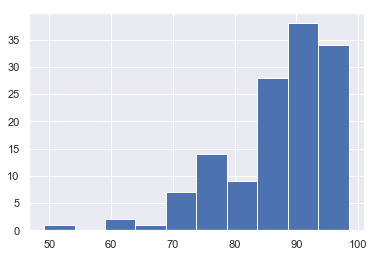

In [163]:
by_property['P e r c e n t a g e   o f   R e n t   P a i d   m e a n'].hist()

In [164]:
monthly_percent_collected["CTYNAME"] = monthly_percent_collected["County"] + " County"

In [165]:
#need to map on FIPS code to be able to map data 
df_sample = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/minoritymajority.csv')
df_sample_r = df_sample[df_sample['STNAME'] == 'California']

In [166]:
df_sample_r = df_sample_r[["FIPS","CTYNAME"]]

In [167]:
county_map = monthly_percent_collected.merge(df_sample_r,on="CTYNAME",how="right")

In [168]:
county_map = county_map[["FIPS","Percentage of Rent Paid"]].rename(columns={"FIPS":"id","Percentage of Rent Paid":"rate"})

In [169]:
county_map['rate'] = county_map['rate'].fillna(0.1)

In [170]:
county_map['rate'] = np.log2(county_map['rate'])

In [171]:
county_map.to_csv("counties_map.csv")

In [172]:
from vega_datasets import data

counties = alt.topo_feature(data.us_10m.url, 'counties')
source = data.unemployment.url

In [173]:
source = "https://raw.githubusercontent.com/qunderriner/eden_rent_roll/main/counties_map.csv"

In [ ]:
alt.Chart(counties).mark_geoshape().encode(
    color='rate:Q'
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(source, 'id', ['rate'])
).project(
    type='albersUsa'
).properties(
    width=500,
    height=300
)

Does subsidy status change over time?

In [175]:
subsidized_filter = [x for x in df_final.columns if x.startswith('Is')]
fixed_filer = [x for x in df_final.columns if x.startswith('Fixed Income?')]

In [176]:
sub_status = df_final[subsidized_filter]

In [177]:
fixed_status = df_final[fixed_filer]

In [178]:
fixed_status["Fixed Income? 06/01/19 - 06/30/19"].value_counts()

SS        1416
SSI        790
SS/SSI     658
Name: Fixed Income? 06/01/19 - 06/30/19, dtype: int64

In [179]:
fixed_status = fixed_status.replace({"SS": "Yes", "SSI": "Yes","SS/SSI":"Yes"})

In [180]:
(sub_status.dropna(axis=0, how='all').shape[0] - sub_status.dropna(axis=0, how='any').shape[0])/sub_status.shape[0]

0.04409997596731555

In [181]:
(fixed_status.dropna(axis=0, how='all').shape[0] - fixed_status.dropna(axis=0, how='any').shape[0])/fixed_status.shape[0]

0.12100456621004566

6.3 percent of people have a change of housing subsidy status at some point in the dataset. 12.4 percent of people have a change of SS/SSI status. 

Q: “(was there more of a drop off [in number of tenants who have moved out]) this year compared to last? Were those dropoffs more concentrated in a certain month?)”

In [182]:
#rerun this function without dropping the period column. I ran this all in a seperate notebook, but wanted
#the code in the same place 
def read_in2(file,sheet):
    """
    inputs:
        file (str): filepath of excel file
        sheet (str): name of sheet in excel sheet
    returns:
        df (dataframe)
    Read in data from a given excel sheet, do some cleaning and then 
    make new column names that adds the date for financial transaction 
    and drops the rest of the data. 
    """
    df = pd.read_excel(file,sheet_name =sheet)
    new_header = df.iloc[4] #grab the forth row for the header
    df = df[5:] #take the data less the blank rows
    df.columns = new_header
    df = df[:-2]#drop bottom two rows, which contain summary info
    df = df.reset_index().drop(columns=["index"])
    df = df[['Tenant Lease Charge','Is Subsidized?', 'Fixed Income?', 'Tenant Rent Collected',
             'Percent Collected',"Period","Tenant"]]
    df = df.rename(columns={"Tenant Lease Charge":"Tenant Lease Charge"+" "+df["Period"][5],
                   "Tenant Rent Collected":"Tenant Rent Charge"+" "+df["Period"][5],
                  "Percent Collected":"Tenant Percent Collected"+" "+df["Period"][5],
                   'Is Subsidized?':"Is Subsidized?"+" "+df["Period"][5], 
                    'Fixed Income?':"Fixed Income?"+" "+df["Period"][5]}) 
    #df = df.drop(columns={"Period"})
    return df

In [183]:
df = read_in_check_status(file2,may19_sept19[0])

df_list = [df, read_in2(file2,may19_sept19[1]),
           read_in2(file2,may19_sept19[2]),
           read_in2(file2,may19_sept19[3]),
           read_in2(file2,may19_sept19[4]),
           read_in2(file1,may2020_sept2020[0]),
           read_in2(file1,may2020_sept2020[1]),
           read_in2(file1,may2020_sept2020[2]),
           read_in2(file1,may2020_sept2020[3]),
           read_in2(file1,may2020_sept2020[4])]

In [185]:
#get total number of people in units 
for i in range(len(df_list)):
    date = df_list[i]["Period"][0][-8:]
    
    print(date,len(df_list[i]))

05/31/19 9504
06/30/19 9504
07/31/19 9504
08/31/19 9504
09/30/19 9504
05/31/20 9362
06/30/20 9372
07/31/20 9391
08/31/20 9502
09/30/20 9501


In [186]:
#set difference figures 
last_period = set(df_list[0]["Tenant"].unique())
for i in range(len(df_list)):
    date = df_list[i]["Period"][0][-8:]
    if i !=0:
        last_period = set(df_list[i-1]["Tenant"].unique())
        this_period = set(df_list[i]["Tenant"].unique())
        print(date,len(last_period.difference(this_period)))

06/30/19 0
07/31/19 0
08/31/19 0
09/30/19 0
05/31/20 439
06/30/20 39
07/31/20 78
08/31/20 185
09/30/20 1


Analysis of new properties 

In [ ]:
check_if_good = pd.read_csv("Inital_eden_rent_roll_data_19-20_v2.csv")

In [ ]:
all_hands_on_the_bad_ones = ['Stone Pine Meadows','Quail Run Apartments','Lincoln Corner Apartments',
'Vacaville Meadows Drive','Orchard/Maples Apartments','Willows Apartments',
'Highlands Apartments', 'Hillside Senior Apartments']

In [ ]:
len(all_hands_on_the_bad_ones)

In [ ]:
check_if_good = check_if_good[check_if_good["Property Name"].isin(all_hands_on_the_bad_ones)]

In [ ]:
fixed_cols_test = ['Property', 'Property Name', 'City', 'County']
percent_collected_test = [num for num in check_if_good.columns if ("Percent") in num]
collect_test = fixed_cols_test + percent_collected_test
df_test = check_if_good[collect_test]

In [ ]:
#we lost 742 records if we drop all hands on the bad one. 
len(df_test.round(2))

In [ ]:
len(check_if_good1)